# Regresja liniowa: nadmierne dopasowanie i regularyzacja

W tym zadaniu zobaczymy, jak modele liniowe przetrenowują się, zrozumiemy, dlaczego tak się dzieje i dowiemy się, jak diagnozować i kontrolować przetrenowanie.

We wszystkich komórkach, w których znajduje się komentarz z instrukcjami, należy napisać kod wykonujący te instrukcje. Pozostałe komórki z kodem (bez komentarzy) należy po prostu wykonać. Ponadto zadanie wymaga udzielenia odpowiedzi na pytania; odpowiedzi należy wpisać po wyróżnionym słowie "__Answer:__".

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Będziemy pracować ze zbiorem danych "bikes_rent.csv", który zawiera informacje kalendarzowe i warunki pogodowe, które charakteryzują zautomatyzowane punkty wypożyczania rowerów, a także liczbę wypożyczeń w danym dniu. Te ostatnie będziemy przewidywać; w ten sposób rozwiążemy problem regresji.

## Zapoznanie się z danymi

## Zadanie 1

Załaduj zestaw danych za pomocą funkcji __pandas.read_csv__ do zmiennej __df__. Wydrukuj pierwsze 5 wierszy, aby upewnić się, że dane zostały poprawnie odczytane:

In [2]:
df = pd.read_csv("bikes_rent.csv")
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Dla każdego dnia roboczego znane są następujące atrybuty:
* _season_: 1 - wiosna, 2 - lato, 3 - jesień, 4 - zima.
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: od 1 do 12.
* _holiday_: 0 - brak wakacji, 1 - wakacje.
* _weekday_: 0 do 6
* _workingday_: 0 oznacza dzień wolny od pracy, 1 oznacza dzień roboczy.
* _weathersit_: ocena korzystnej pogody od 1 (czysty, pogodny dzień) do 4 (ulewny deszcz, mgła)
* _temp_: temperatura w stopniach Celsjusza.
* _atemp_: temperatura w stopniach Celsjusza.
* _hum_: wilgotność
* _windspeed(mph)_: prędkość wiatru w milach na godzinę.
* _windspeed(ms)_: prędkość wiatru w metrach na sekundę.
* _cnt_: liczba wypożyczonych rowerów (jest to atrybut docelowy, będziemy go przewidywać).

Mamy więc cechy rzeczywiste, binarne i nominalne (porządkowe), a wszystkie z nich można traktować jako cechy rzeczywiste. Atrybuty nominalne mogą być również traktowane jako rzeczywiste, ponieważ mają porządek. Zobaczmy na wykresach, jak cecha docelowa zależy od innych cech

Wykres zależności atrybutów od liczby przejazdów. Innymi słowy, należy zbudować 12 wykresów. Każdy z nich powinien pokazywać zależność kolejnego atrybutu od zmiennej **cnt**.

In [3]:
all_columns = df.columns
print(all_columns)

Index(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)',
       'cnt'],
      dtype='object')


season


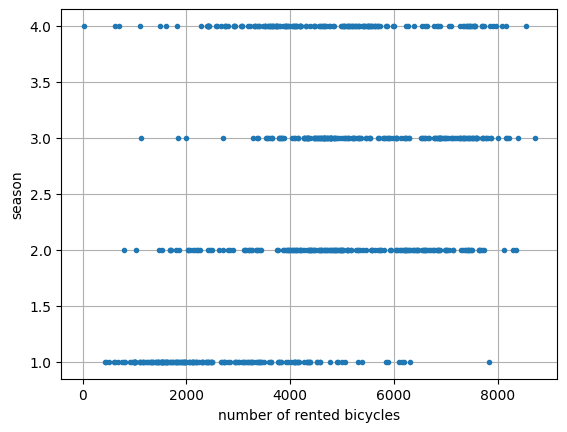

yr


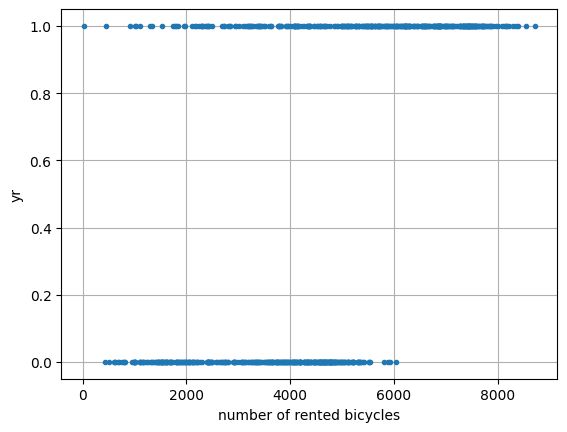

mnth


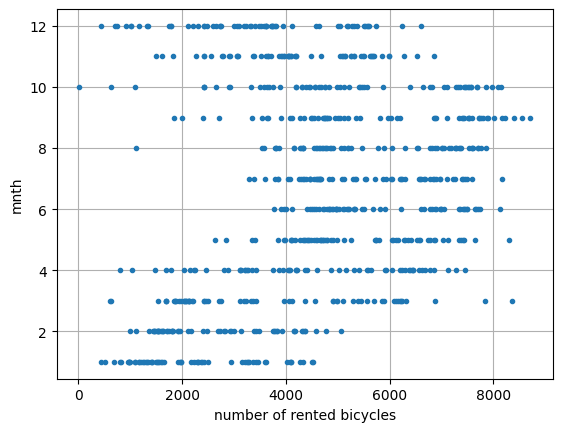

holiday


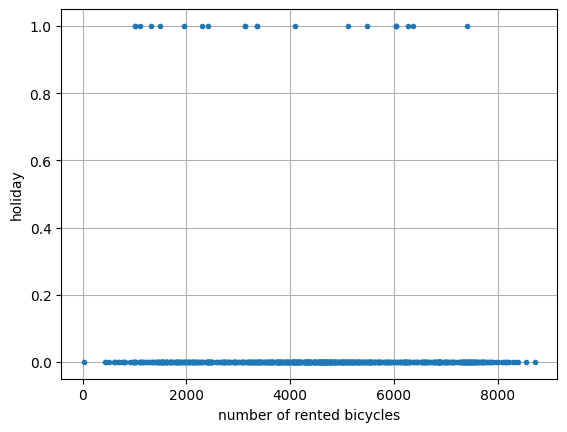

weekday


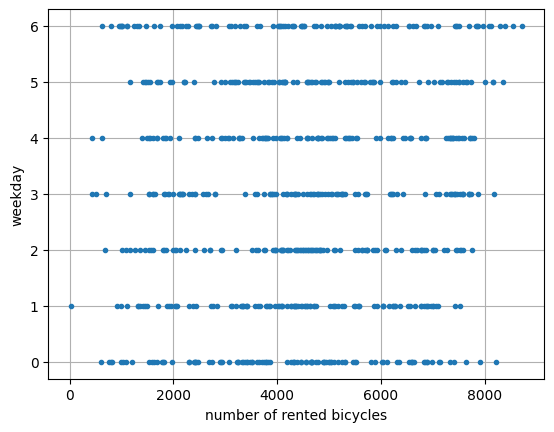

workingday


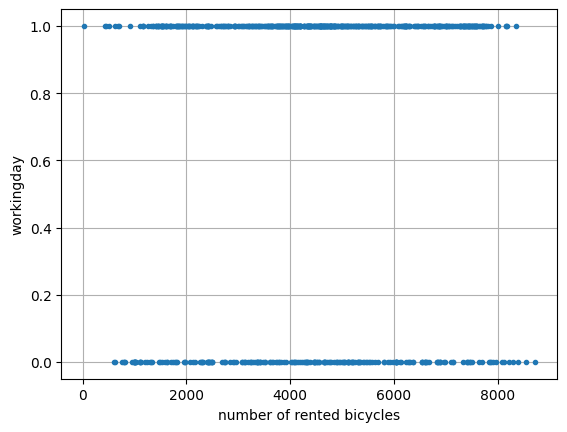

weathersit


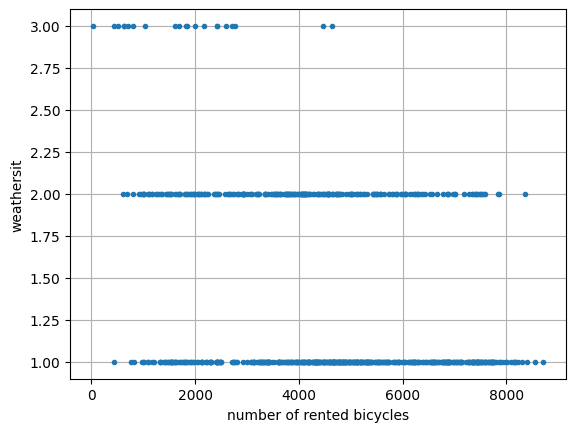

temp


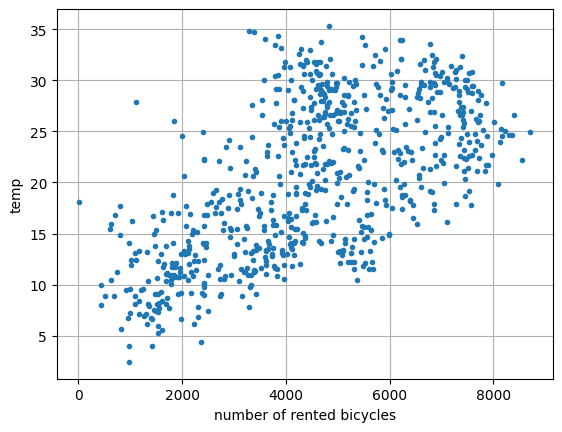

atemp


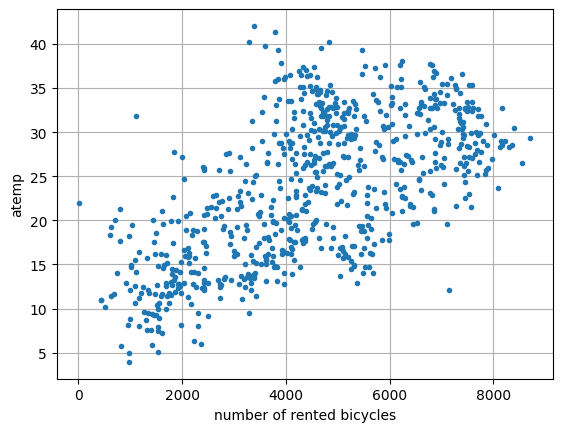

hum


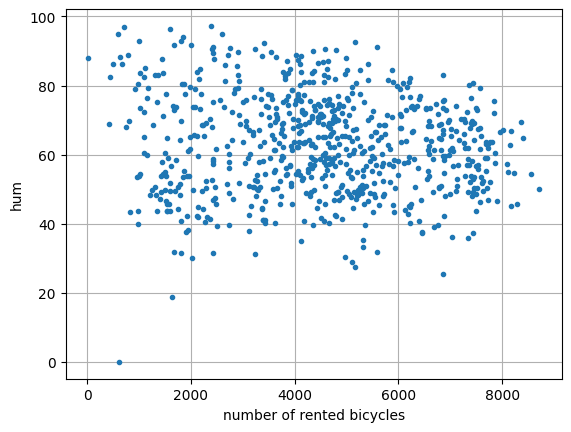

windspeed(mph)


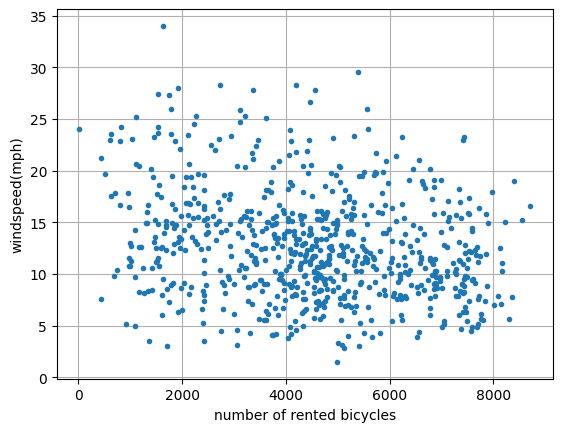

windspeed(ms)


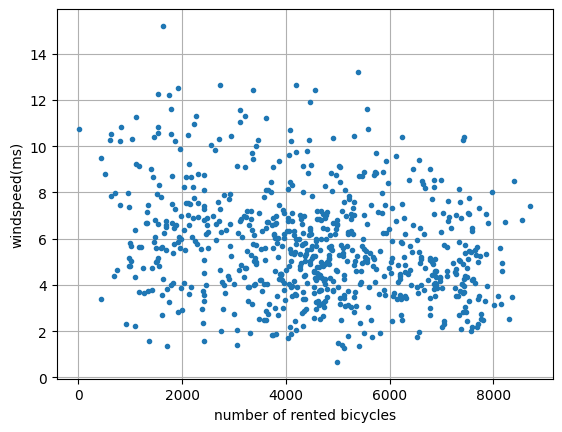

In [4]:
# Put you code here
for column in df.columns[0:-1]:
    print(column)
    plt.plot(df["cnt"], df[column], ".")
    plt.grid(True)
    plt.xlabel("number of rented bicycles")
    plt.ylabel(f"{column}")
    plt.show()

__Pytania:__
1. Jaka jest natura zależności liczby wypożyczeń od miesiąca? 
__Answer:__ Sinusoidalnie zmienna
1. Podaj jedną lub dwie cechy, od których liczba wypożyczeń najprawdopodobniej zależy liniowo
__Answer:__ Temperatura, temperatura odczuwalna

## Zadanie 2

Bardziej rygorystycznie oceńmy poziom zależności liniowej między cechami a zmienną docelową. Dobrą miarą zależności liniowej między dwoma wektorami jest korelacja Pearsona. Mieliśmy już z nią do czynienia wcześniej. Aby ją obliczyć w pandach, możemy skorzystać z metod dataframe: corr i corrwith.

Oblicz korelacje wszystkich cech oprócz ostatniej z ostatnią cechą za pomocą metody `corrwith`.

In [5]:
corr = df[all_columns[0:-1]].corrwith(df[all_columns[-1]])
print(corr)

    


season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64




```
# Wybrany format kodu
```

Istnieją cechy w próbce, które korelują z cechą docelową, co oznacza, że problem można rozwiązać za pomocą metod liniowych.

Z wykresów widzimy, że niektóre cechy są do siebie podobne. Obliczmy więc również korelacje między rzeczywistymi atrybutami.

## Zadanie 3

Oblicz korelacje parami między cechami temp, atemp, hum, windspeed(mph), windspeed(ms) i cnt
przy użyciu metody corr:

In [6]:
corr = df[["temp", "atemp", "hum", "windspeed(mph)", "windspeed(ms)", "cnt"]].corr()

print(corr)

                    temp     atemp       hum  windspeed(mph)  windspeed(ms)  \
temp            1.000000  0.991702  0.126963       -0.157944      -0.157944   
atemp           0.991702  1.000000  0.139988       -0.183643      -0.183643   
hum             0.126963  0.139988  1.000000       -0.248489      -0.248489   
windspeed(mph) -0.157944 -0.183643 -0.248489        1.000000       1.000000   
windspeed(ms)  -0.157944 -0.183643 -0.248489        1.000000       1.000000   
cnt             0.627494  0.631066 -0.100659       -0.234545      -0.234545   

                     cnt  
temp            0.627494  
atemp           0.631066  
hum            -0.100659  
windspeed(mph) -0.234545  
windspeed(ms)  -0.234545  
cnt             1.000000  


Na przekątnych, tak jak powinno być, znajdują się jednostki. Jednak w macierzy znajdują się jeszcze dwie pary silnie skorelowanych kolumn: temp i atemp (skorelowane z natury) oraz dwie prędkości wiatru (ponieważ jest to tylko tłumaczenie niektórych jednostek na inne). Dalej zobaczymy, że fakt ten negatywnie wpływa na uczenie modelu liniowego.

Na koniec przyjrzyjmy się średniej cech (metoda średniej), aby oszacować skalę cech i ułamek 1 w cechach binarnych.

## Zadanie 4

Wyznacz średnią cech

In [7]:
# Put your code here
features_mean = df.mean()
print(features_mean)

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64


Atrybuty mają różne skale, więc do dalszej pracy lepiej znormalizujemy macierz obiekt-atrybut.

### Problem pierwszy: cechy współliniowe

Tak więc w naszych danych jedna cecha duplikuje inną cechę i istnieją jeszcze dwie bardzo podobne cechy. Oczywiście moglibyśmy od razu usunąć duplikaty, ale zobaczmy, jak wyglądałby trening modelu, gdybyśmy nie zauważyli tego problemu.

Po pierwsze, wykonajmy skalowanie lub standaryzację cech: od każdej cechy odejmiemy jej średnią i podzielimy ją przez jej odchylenie standardowe. Można to zrobić za pomocą metody skalowania.

Ponadto musimy wymieszać próbkę do walidacji krzyżowej.

In [8]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [9]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]




In [10]:
print(f"df_shuffled = \n{df_shuffled}")


df_shuffled = 
     season  yr  mnth  holiday  weekday  workingday  weathersit       temp  \
703       4   1    12        0        2           1           1  19.509153   
33        1   0     2        0        4           1           1   7.665237   
300       4   0    10        0        5           1           2  13.564153   
456       2   1     4        0        0           0           2  17.459153   
633       4   1     9        0        2           1           1  22.550000   
..      ...  ..   ...      ...      ...         ...         ...        ...   
71        1   0     3        0        0           0           1  15.758268   
106       2   0     4        0        0           0           1  18.723347   
270       4   0     9        0        3           1           2  26.035000   
435       1   1     3        0        0           0           1  14.831299   
102       2   0     4        0        3           1           2  16.912500   

        atemp      hum  windspeed(mph)  windspee

In [11]:
print(f"X = \n{X}")


X = 
[[ 1.354375    0.99863295  1.58866019 ...  0.74372737 -0.21121111
  -0.21121111]
 [-1.34821315 -1.00136893 -1.31026791 ... -1.33538868  1.12681211
   1.12681211]
 [ 1.354375   -1.00136893  1.00887457 ... -0.29551449  0.50349108
   0.50349108]
 ...
 [ 1.354375   -1.00136893  0.71898176 ...  1.55169951 -0.5404777
  -0.5404777 ]
 [-1.34821315  0.99863295 -1.0203751  ... -1.06046036  0.41449871
   0.41449871]
 [-0.44735043 -1.00136893 -0.73048229 ...  1.34385394  0.77643372
   0.77643372]]


In [12]:
print(f"y = \n{y}")

y = 
703    6606
33     1550
300    3747
456    6041
633    7538
       ... 
71     2417
106    3744
270    3907
435    4911
102    2162
Name: cnt, Length: 731, dtype: int64


Przetrenujmy regresję liniową na naszych danych i przyjrzyjmy się wagom cech.

In [13]:
from sklearn.linear_model import LinearRegression

## Zadanie 5

Utwórz obiekt regresora liniowego, wytrenuj go na wszystkich danych i wyprowadź wagi modelu (wagi są przechowywane w zmiennej `coef_` klasy regresora). Możesz wyprowadzić pary (nazwa funkcji, waga) za pomocą funkcji `zip` wbudowanej w język Python. Nazwy cech są przechowywane w zmiennej `df.columns`.


In [14]:
# Put your code here
linear_regressor = LinearRegression()

In [15]:
linear_regressor.fit(X, y)
feature_coefficient_pairs = list(zip(df.columns, linear_regressor.coef_) )
for pair in feature_coefficient_pairs:
    print(pair)


('season', 570.863641661725)
('yr', 1021.9604245185086)
('mnth', -141.3006331900142)
('holiday', -86.75760471139698)
('weekday', 137.2272583151452)
('workingday', 56.38980357474366)
('weathersit', -330.2271825899341)
('temp', 367.4799030832653)
('atemp', 585.5521797658965)
('hum', -145.6155228231448)
('windspeed(mph)', 12454356291009.727)
('windspeed(ms)', -12454356291208.188)


Widzimy, że wagi dla cech zależnych liniowo są modulo znacznie większe niż dla innych cech. Aby zrozumieć, dlaczego tak się dzieje, przypomnijmy wzór analityczny używany do obliczania wag modelu liniowego w metodzie najmniejszych kwadratów:

$$w = (X^TX)^{-1} X^T y$$.

Jeśli $X$ ma współliniowe (liniowo zależne) kolumny, macierz $X^TX$ staje się zdegenerowana, a wzór nie jest już poprawny. Im bardziej zależne są cechy, tym mniejszy jest wyznacznik tej macierzy i tym gorsze przybliżenie $Xw \approx y$. Sytuacja ta nazywana jest _problemem wieloliniowości_.

Nie stało się tak w przypadku pary (temp, atemp) nieco mniej skorelowanych zmiennych, ale w praktyce zawsze warto uważnie obserwować współczynniki pod kątem podobnych znaków.

Aby rozwiązać problem wieloliniowości, musimy użyć regularyzatora. Do optymalizowanej funkcji dodaje się $L_1$ lub $L_2$ normę wag pomnożoną przez współczynnik regularyzacji $\alpha$. W pierwszym przypadku metoda nazywana jest Lasso, a w drugim --- Ridge

### Zadanie 6
Spróbujmy wytrenować modele liniowe z regularyzacją $L_1$ i $L_2$, a następnie porównajmy ich wagi. Wytrenuj regresory Ridge i Lasso z domyślnymi parametrami i zobacz, że problem z wagami został rozwiązany.

Wytrenować model liniowy z $L_1$-regularizacją (klasa Lasso) i wyprowadzić wagi

In [16]:
from sklearn.linear_model import Lasso, Ridge

In [17]:
# Put your code here
linear_regressor_with_L1 = Lasso(alpha=1)
linear_regressor_with_L1.fit(X, y)
feature_coefficient_pairs_L1 = list(zip(df.columns, linear_regressor_with_L1.coef_) )
for pair in feature_coefficient_pairs_L1:
    print(pair)

('season', 560.2416160308861)
('yr', 1019.4634940657196)
('mnth', -128.73062703678696)
('holiday', -86.15278133371106)
('weekday', 137.34789390496314)
('workingday', 55.21237064135668)
('weathersit', -332.3698569623487)
('temp', 376.3632362096943)
('atemp', 576.530793504555)
('hum', -144.12915500348583)
('windspeed(mph)', -197.1396894024843)
('windspeed(ms)', -2.8051404183533485e-08)


Wytrenować model liniowy z $L_2$-regularizacją (klasa Ridge) i wyprowadzić wagi

In [18]:
# Put your code here
linear_regressor_with_L2 = Ridge(alpha=1)
linear_regressor_with_L2.fit(X, y)
feature_coefficient_pairs_L2 = list(zip(df.columns, linear_regressor_with_L2.coef_) )
for pair in feature_coefficient_pairs_L2:
    print(pair)

('season', 563.0645722520164)
('yr', 1018.9483787875275)
('mnth', -131.87332028247582)
('holiday', -86.74609799709243)
('weekday', 138.00511117871926)
('workingday', 55.90311037506429)
('weathersit', -332.34978849907236)
('temp', 386.45788919189926)
('atemp', 566.3470470600766)
('hum', -145.0713272986732)
('windspeed(mph)', -99.25944108174306)
('windspeed(ms)', -99.25944115438946)


### Zadanie 7

W przeciwieństwie do regularyzacji $L_2$, $L_1$ zeruje wagi dla niektórych cech. Zaobserwujmy, jak zmieniają się wagi wraz ze wzrostem współczynnika regularyzacji $\alpha$.

Dla każdej wartości współczynnika z `alphas`, wytrenuj regresor `Lasso` i zapisz wagi do listy `coefs_lasso`, a następnie wytrenuj `Ridge` i zapisz wagi do listy `coefs_ridge`. Przekonwertuj wynikowe listy na `np.array`.

In [19]:
alphas = np.arange(1, 500, 50)

coefs_lasso = []
coefs_ridge = []

for alpha in alphas:
    lin_reg_L1 = Lasso(alpha=alpha)
    lin_reg_L1.fit(X, y)
    coefs_lasso.append(lin_reg_L1.coef_)

    lin_reg_L2 = Ridge(alpha=alpha)
    lin_reg_L2.fit(X, y)
    coefs_ridge.append(lin_reg_L2.coef_)
    # Put your code here

# Put your code here
coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)

Przeanalizuj dynamikę wag w miarę zwiększania parametru regularyzacji:

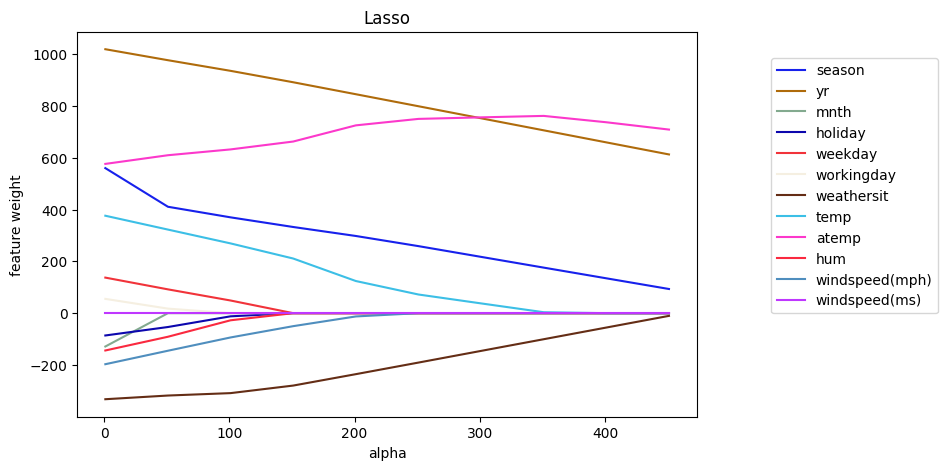

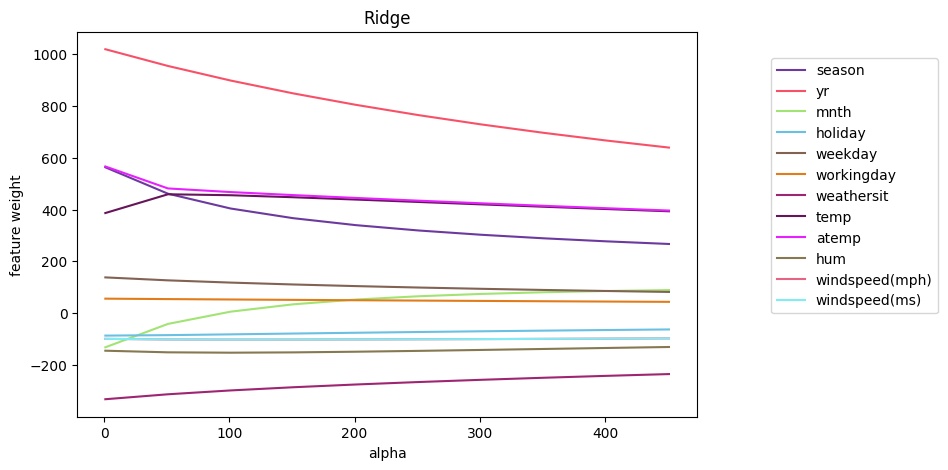

In [20]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Przeanalizuj wykresy i odpowiedz na poniższe pytania.

1. Który regularyzator (Ridge czy Lasso) bardziej agresywnie redukuje wagi dla tej samej wartości alfa?
__Answer:__ Lasso
2. Co dzieje się z wagami Lasso, jeśli wartość alfa jest bardzo duża? Wyjaśnij, dlaczego tak się dzieje.
__Answer:__ Duża część wag ulega wyzerowaniu. Dzieje się tak, ponieważ przy dużych wartościach alfa, wartości wag mają znacznie większy wpływ na funkcję błędu niż samo dopasowanie modelu.
3. Czy można argumentować, że `Lasso` eliminuje jedną z cech `prędkość wiatru` dla dowolnej wartości `alfa > 0`? A Ridge? Mówi się, że regularyzator wyklucza cechę, jeśli współczynnik dla niej jest mniejszy niż $10^{-3}$.
__Answer:__ Lasso faktycznie eliminuje jedną z cech liniowo zależnych dla dowolnej wartości alpha. W przypadku Ridge tak nie jest
4. Który regularyzator jest odpowiedni do wybierania nieinformatywnych cech?
__Answer:__ Lasso

### Zadanie 8

Następnie będziemy pracować z `Lasso'.

Widzimy więc, że gdy zmieniamy alfa, model inaczej dopasowuje współczynniki cech. Musimy wybrać najlepszą wartość alfa.

W tym celu potrzebujemy przede wszystkim metryki jakości. Jako metryki użyjemy samej zoptymalizowanej funkcji najmniejszych kwadratów, tj. błędu średniokwadratowego.

Po drugie, musimy zrozumieć, na jakich danych obliczyć tę metrykę. Nie możemy wybrać "alfa" na podstawie wartości MSE na próbce treningowej, ponieważ wtedy nie możemy ocenić, w jaki sposób model będzie przewidywał na nowych danych. Jeśli wybierzemy jedną próbkę podzieloną między próbkę treningową i testową (nazywa się to wstrzymaniem), dostroimy się do konkretnych "nowych" danych i możemy ponownie przetrenować. Dlatego wykonamy kilka podziałów próbek, wypróbujemy różne wartości alfa dla każdej z nich, a następnie uśrednimy MSE. Wygodniej jest dokonać takich podziałów za pomocą walidacji krzyżowej, tj. podzielić próbkę na części $K$ i za każdym razem wziąć jedną z nich jako testową, a z pozostałych bloków utworzyć próbkę szkoleniową.

Przeprowadzenie walidacji krzyżowej dla regresji w sklearn jest dość proste: istnieje specjalny regresor do tego celu, __LassoCV__, który pobiera jako dane wejściowe listę alfa i dla każdego z nich oblicza MSE na walidacji krzyżowej. Po treningu (jeśli pozostawimy domyślny parametr cv=3), regresor będzie zawierał zmienną __mse\_path\___, macierz o rozmiarze len(alpha) x k, k = 3 (liczba bloków w walidacji krzyżowej), zawierającą wartości MSE na teście dla odpowiednich przebiegów. Ponadto zmienna alpha\_ będzie przechowywać wybraną wartość parametru regularyzacji, a coef\_ będzie tradycyjnie przechowywać wytrenowane wagi odpowiadające tej alpha_.

Należy pamiętać, że regresor może zmienić kolejność, w jakiej działa na alphas; lepiej jest użyć zmiennej regresora alphas_, aby dopasować ją do macierzy MSE.

Wytrenuj regresor `LassoCV` na wszystkich parametrach regularyzacji od alfa. Wykreśl linie _averaged_ over `MSE` jako funkcję `alpha` (w tym celu użyj funkcji `create_plot`).

Wyprowadź wybraną wartość `alpha`, jak również pary cecha-współczynnik dla wytrenowanego wektora współczynników.

In [21]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    # x = map(lambda e: e[0], data)
    # y = map(lambda e: e[1], data)

    x = data[0]
    y = data[1]

    
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()

In [32]:
from sklearn.linear_model import LassoCV

alphas = np.arange(1, 100, 5)
k = 3

regressor = LassoCV(alphas=alphas, cv=k)
regressor.fit(X, y)

alpha_opt = regressor.alpha_
feature_coefficient_Lasso_CV_pairs = list(zip(df.columns, regressor.coef_))

print(f"Alpha = {alpha_opt}")
for pair in feature_coefficient_Lasso_CV_pairs:
    print(pair)





Alpha = 6
('season', 532.0189828413535)
('yr', 1015.0602226430595)
('mnth', -100.03952614356629)
('holiday', -83.29395987529904)
('weekday', 132.50446549095795)
('workingday', 51.557085614073735)
('weathersit', -330.5598567399817)
('temp', 370.67985503003405)
('atemp', 581.396931065498)
('hum', -140.00740550068844)
('windspeed(mph)', -191.77140847135036)
('windspeed(ms)', -2.6854702314758792e-08)


In [33]:
reg_alphas = regressor.alphas_
reg_mse = regressor.mse_path_
avg_mse = reg_mse.mean(axis=1)
print(reg_alphas)
print(reg_mse)
print(avg_mse)


[96 91 86 81 76 71 66 61 56 51 46 41 36 31 26 21 16 11  6  1]
[[830768.68693702 919721.93589263 805481.54522903]
 [822965.9041311  911867.54470864 804343.02766965]
 [815129.08593972 903855.55058088 803483.74706928]
 [807667.98224742 896148.95236924 802906.09265381]
 [800137.23263318 888747.72399201 801974.9311743 ]
 [793005.6616591  881651.8631318  800937.92121215]
 [786275.36724172 874861.36810104 799342.37031522]
 [779946.35004807 868376.23749144 798151.12777192]
 [774018.6100807  862196.47012638 797363.63293845]
 [768492.14733962 856322.06502308 796979.89551936]
 [763366.96182482 850359.8722302  796999.92588657]
 [758643.05353631 844566.95589129 797423.73295863]
 [754320.42247408 839080.96310802 798251.32439694]
 [750399.06863813 833901.906581   799482.70678255]
 [746878.99046623 829029.79332371 801117.80350671]
 [742255.05212855 824464.62917087 801674.30830821]
 [738465.37393446 819052.82694159 802734.32163988]
 [735622.01588326 810953.6137859  804327.50220445]
 [733725.76040522 80

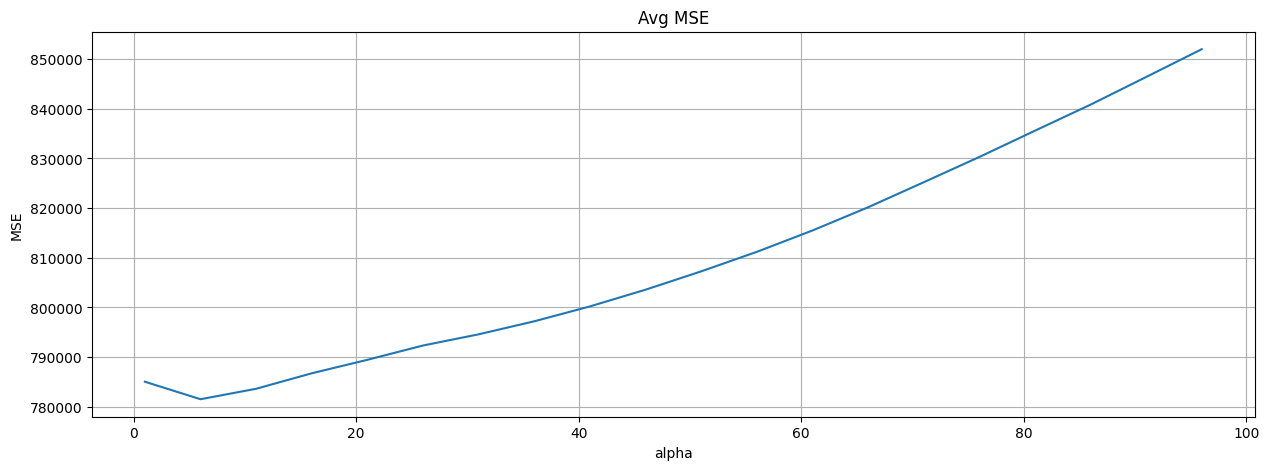

In [34]:

create_plot((reg_alphas, avg_mse), "Avg MSE", "alpha", "MSE")

Wybraliśmy więc pewien parametr regularyzacji. Zobaczmy, jaki parametr alfa wybralibyśmy, gdybyśmy podzielili próbkę tylko raz na trening i test, tj. rozważyli trajektorie MSE odpowiadające oddzielnym blokom próbki.

### Zadanie 9

Wyprowadź wartości `alpha` odpowiadające minimom `MSE` na każdej partycji (tj. według kolumn).
Wizualizacja kolumn `mse_path_` na trzech oddzielnych wykresach.


Alphas with minimum MSE:


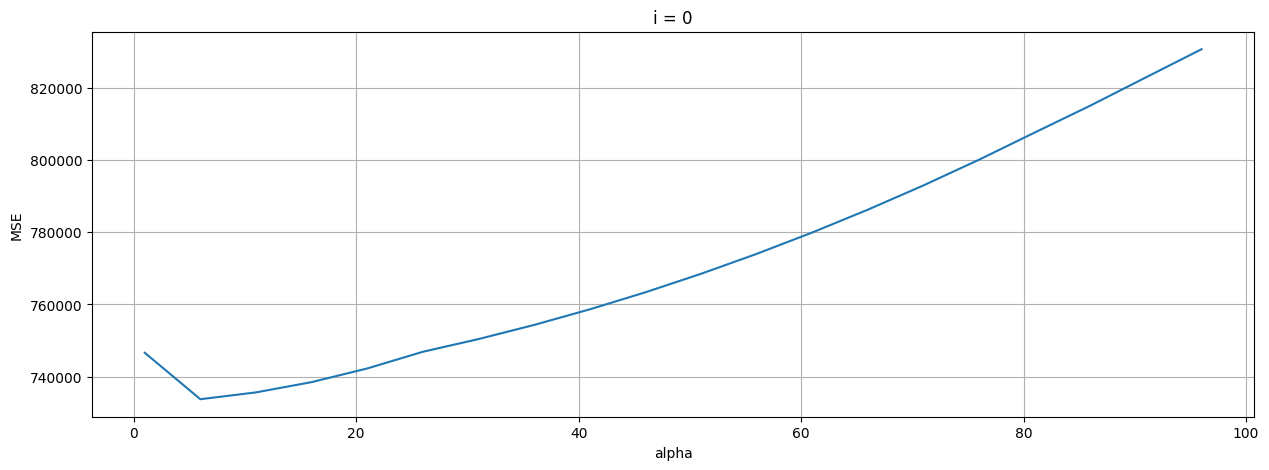

Alpha = 6, MSE = 733725.7604052245


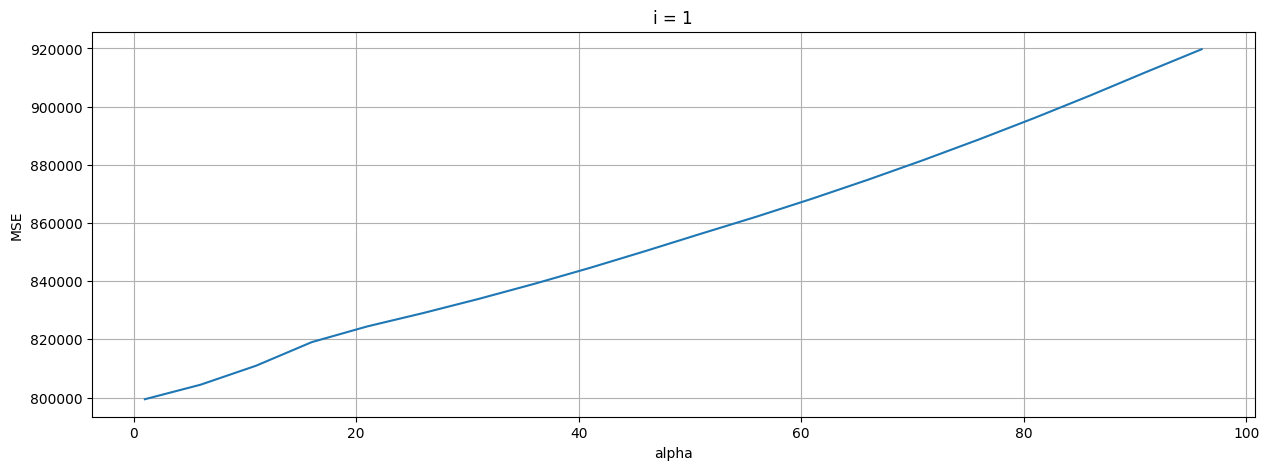

Alpha = 1, MSE = 799433.1673691699


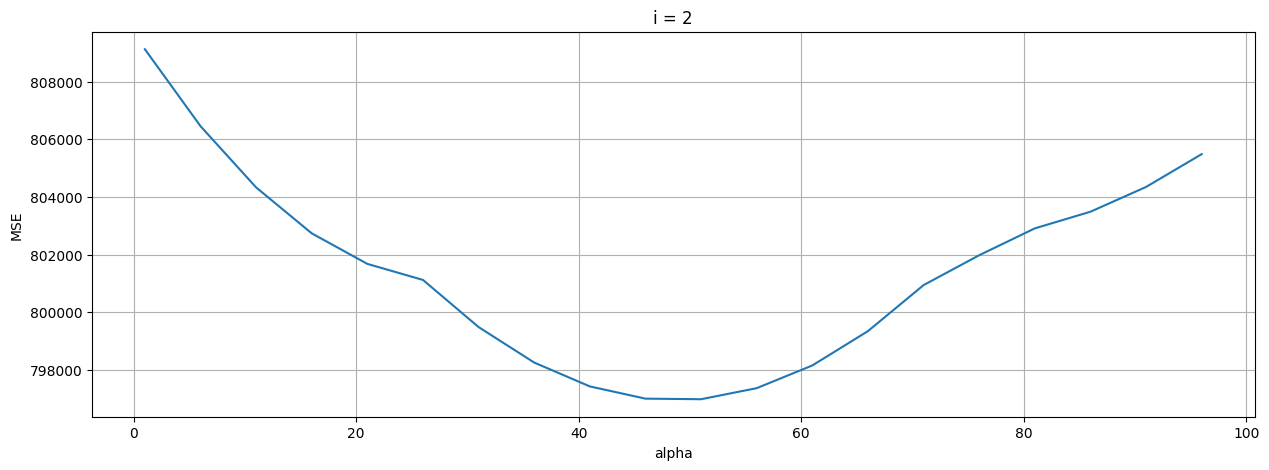

Alpha = 51, MSE = 796979.8955193633


In [35]:
print("Alphas with minimum MSE:")
for i in range(k):
    mse = reg_mse[:, i]
    min_index = mse.argmin()
    min_mse = mse.min()
    min_mse_alpha = reg_alphas[min_index]

    create_plot((reg_alphas, mse), f"i = {i}", "alpha", "MSE")
    print(f"Alpha = {min_mse_alpha}, MSE = {min_mse}")
    
# Put your code here

W każdej partycji optymalna wartość "alfa" jest inna i odpowiada dużemu MSE w innych partycjach. Okazuje się, że dostosowujemy się do konkretnych próbek treningowych i kontrolnych. Kiedy wybieramy `alpha` w walidacji krzyżowej, wybieramy coś "średniego", co da akceptowalną wartość metryki na różnych partycjach próbki.

### Zadanie 10

Na koniec, jak to zwykle bywa w analizie danych, zinterpretujmy wynik. Odpowiedz na następujące pytania.

#### Pytanie 1

W ostatnim wytrenowanym modelu wybierz 4 cechy o najwyższych (dodatnich) współczynnikach (i wypisz je), spójrz na wizualizacje zależności `cnt` od tych cech, które narysowaliśmy w bloku "Poznawanie danych". Czy na wykresach widać rosnącą liniową zależność `cnt` od tych cech? Czy logiczne jest twierdzenie (wynikające ze zdrowego rozsądku), że im większa wartość tych atrybutów, tym więcej osób będzie chciało wypożyczyć rowery?

__Odpowiedź:__

In [47]:
sorted_feat_coef_list = []
feat_coef_list_to_sort = feature_coefficient_Lasso_CV_pairs.copy()



while feat_coef_list_to_sort:
    act_max = feat_coef_list_to_sort[0]
    for pair in feat_coef_list_to_sort:
        if pair[1] > act_max[1]:
            act_max = pair

    sorted_feat_coef_list.append(act_max)
    feat_coef_list_to_sort.remove(act_max)

for pair in sorted_feat_coef_list[0:4]:
    print(pair)


('yr', 1015.0602226430595)
('atemp', 581.396931065498)
('season', 532.0189828413535)
('temp', 370.67985503003405)


W miarę widać. Fakt, że akurat te cztery cechy mają najwyższe wagi też można wywnioskować porównując ze sobą wykresy poszczególnych cech od cnt.

#### Pytanie 2

Wybierz 3 cechy o największych współczynnikach modulo ujemnych (i wypisz je), spójrz na odpowiednie wizualizacje. Czy widoczna jest malejąca zależność liniowa? Czy logiczne jest stwierdzenie, że im większa wielkość tych cech, tym mniej osób będzie chciało wsiąść na rower?

__Odpowiedź:__

In [52]:
sorted_feat_coef_list.reverse()
for pair in sorted_feat_coef_list[0:3]:
    print(pair)

('weathersit', -330.5598567399817)
('windspeed(mph)', -191.77140847135036)
('hum', -140.00740550068844)


Nie jest to tak wyraźne jak w przypadku cech "najbardziej dodatnich" ale trochę widać. Wagi najbardziej ujemne są co do wartości bezwględnej mniejsze niż wagi dodatnie stąd ich malejąca zależność od cnt jest mniej widoczna niż w przypadku dodatnich.

#### Pytanie 3

Wypisz znaki ze współczynnikami bliskimi zeru (< 1e-3). Jak myślisz, dlaczego model wykluczył je z modelu (spójrz ponownie na wykresy)? Czy to prawda, że nie mają one wpływu na popyt na rowery?

__Odpowiedź:__

In [60]:
for pair in sorted_feat_coef_list:
    if abs(pair[1]) < 1e-3:
        print(pair)

('windspeed(ms)', -2.6854702314758792e-08)


Cecha została wykluczona, ponieważ jest liniowo zależna od innej cechy (windspeed(mph)), a korzystaliśmy z regularyzatora L1, który ma taką właściwość, że wyklucza cechy linowo zależne od innych

### Wnioski
Widzieliśmy więc, jak monitorować adekwatność modelu liniowego, jak wybierać cechy i jak prawidłowo wybrać współczynnik regularyzacji, jeśli to możliwe bez dostosowywania się do określonej części danych.

Warto zauważyć, że wygodnie jest wybrać tylko niewielką liczbę parametrów (1, 2, maksymalnie 3) za pomocą walidacji krzyżowej, ponieważ dla każdej dopuszczalnej kombinacji parametrów musimy trenować model kilka razy. Proces ten zajmuje dużo czasu, zwłaszcza jeśli musimy trenować na dużych ilościach danych.